In [ ]:
import os
import glob
import numpy as np
import pickle
from matplotlib import gridspec

import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import pandas as pd
os.chdir("../")
from helpers.helpers import scatter3d
os.chdir("./plot_notebooks")

## LOAD ALL np random or dirichlet samples

In [ ]:
name = 'none'
ds = []
os.chdir('../../results/npdirichlet')
allfiles = glob.glob("*.pkl")
for file in allfiles:
    if 'dirichlet' in file:
        cur = pd.read_pickle(file)
        cur['sample method'] = 'dirichlet'
        ds.append(cur)
    elif 'nprandom' in file:
        cur = pd.read_pickle(file)
        cur['sample method'] = 'nprandom'
        ds.append(cur)
d=pd.concat(ds)
d['H(Xi)'].apply(lambda row:np.amin(row))
d['I(X1;X2) level'] = d.apply(lambda row:row['I(X1;X2)']/np.amin(row['H(Xi)']),axis=1)
os.chdir('../../code/plot_notebooks')
d.to_pickle("../../results/test/nprandomdirichlet2345.pkl")

## 2D Np random vs dirichlet samples

In [ ]:
d = pd.read_pickle('../../results/nprandomdirichlet2345.pkl')
fig = plt.gcf()
fig.set_size_inches(15,7.5)
xlabel = 'I(X1;X2) level'
ylabel = 'syn_upper'
states=[2,3,4,5]
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0.005, hspace=0.05) # set the spacing between axes. 

for i, idxs in enumerate(states):
    nvar = idxs
    g = sns.jointplot(data=d[d['states']==nvar], x=xlabel, y=ylabel,hue='sample method'
                     ,marginal_ticks=False) 
    g.fig.suptitle("states: "+str(idxs),y=1.0)
    g.set_axis_labels(xlabel,ylabel,fontsize=14)
    gs.tight_layout(fig)
    gs.update(top=0.7)
    plt.show()

## 3D plots dirichlet 

In [11]:
folder = '../../results/'
d = pd.read_pickle(folder+'nprandomdirichlet2345.pkl')
states=[2,3,4]
ds = []
for s in states:
    ds.append(d[d['states']==s].head(1995))
d = pd.concat(ds)

def normupper(row):
    if row['states']==2:
        return row['syn_upper']
    if row['states']==3:
        return row['syn_upper']/1.58
    if row['states']==4:
        return row['syn_upper']/2
    if row['states']==5:
        return row['syn_upper']/2.3219

d['H(X1)'] = d['H(Xi)'].apply(lambda row: row[0])
d['H(X2)'] = d['H(Xi)'].apply(lambda row: row[1])
d['normupper'] = d.apply(lambda row:normupper(row),axis=1)
d['normsyn'] = d['syn_info']/d['syn_upper']
hlabel ='$H_{max}(X)$ / $H(X_{max})$'
d[hlabel] = d.apply(lambda row:normupper(row),axis=1)
d.keys()

Index(['systemID', 'parX', 'pX', 'syn_upper', 'H(Xi)', 'I(X1;X2)', 'shapeS',
       'lenS', 'tot_runtime', 'syn_info', 'srv_data', 'pXS', 'steps', 'lenX',
       'states', 'sample method', 'I(X1;X2) level'],
      dtype='object')


Index(['systemID', 'parX', 'pX', 'syn_upper', 'H(Xi)', 'I(X1;X2)', 'shapeS',
       'lenS', 'tot_runtime', 'syn_info', 'srv_data', 'pXS', 'steps', 'lenX',
       'states', 'sample method', 'I(X1;X2) level', 'H(X1)', 'H(X2)',
       'normupper', 'normsyn', '$H_{max}(X)$ / $H(X_{max})$'],
      dtype='object')

0 2
1 3
2 4


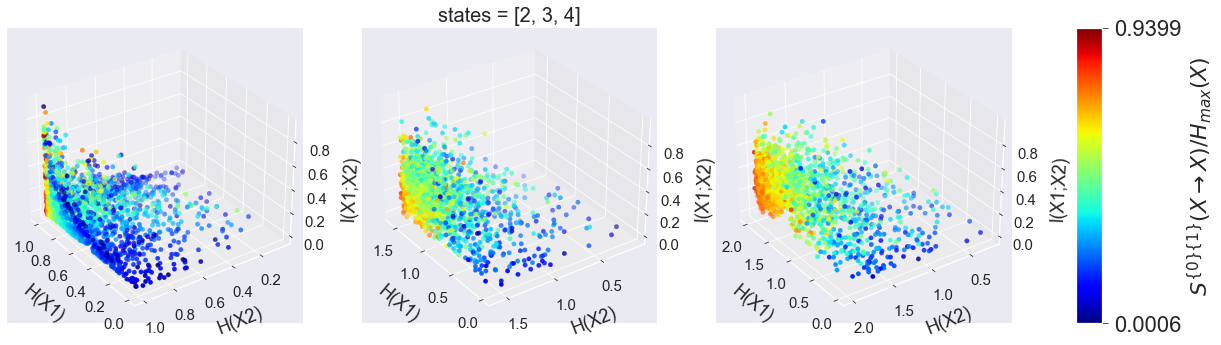

In [13]:
# plots to know what systems there are in the dataset
xcol = 'H(X1)'
ycol = 'H(X2)'
zcol = 'I(X1;X2)'
hue_key='normsyn'

# 3D Plot
plot = d
cm = plt.get_cmap("jet")
states=[2,3,4]
fig,colorbar = scatter3d(plot,xcol,ycol,zcol,hue_key,colorsMap=cm,hue=hue_key,states=states)

if hue_key == 'normupper':
    hlabel = r'$H_{max}(X)$ / $H(X_{max})$'
else:
    hlabel = r'$S^{\{0\}\{1\}}(X\rightarrow X) / H_{max}(X)$'
colorbar.set_label(hlabel,fontsize=22)
colorbar.ax.tick_params(labelsize=22) 
# colorbar.set_ticks([plot[hue_key].min(),plot[hue_key].max()],fontsize=210)
plt.style.use('seaborn-paper')
# plt.savefig("../../results/test/TEST.png")
plt.show()